# Lab 5 - Wide and Deep Network Architectures
Jaryd Domine

Sharon Yang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Imports*

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics as mt
from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, concatenate

#=== We consider a more generalized binary loss: ===
!pip -q install focal-loss
from focal_loss import BinaryFocalLoss

#=== Metrics ===
from tensorflow.keras.metrics import Recall, AUC
!pip -q install tensorflow-addons
from tensorflow_addons.metrics import F1Score

## Preparation

###Description of the dataset

> *1) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).*



####Overview

We use a ***Stroke prediction*** dataset from Kaggle: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset.

The task is to predict whether a patient has had (ultimately, *will* have) a stroke based on features such as gender, age, bmi, medical conditions, smoking status, etc. Each column is a feature, and each row corresponds to a patient.

As we've seen with fraud/disease detection datasets, there is an inherent class imbalance, with positive (stroke) cases making up less than 5% of samples. We discuss the appropriate metrics, methods, and cross validation techniques to handle this imbalance in a realistic way.

Using tensorflow and keras, we will produce several wide and deep (W&D) models, varying their structures, hyperparameters, loss functions, etc. We visualize the performance of these models and perform statistical comparisons.

We then compare our best W&D network to a deep-only network using AUC-ROC.

Finally, we visualize the embeddings of the categorical variables in the deep network and explain any clustering. Due to the small number of classes for each feature, it is not necessary to perform further dimensionality reduction.

---

We load the dataset and make some initial observations:

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/healthcare-dataset-stroke-data.csv')
# df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
print('Dataset consists of',df.shape[0],'samples with',df.shape[1],'features.')
print('---\nFeature datatypes:\n'+str(df.dtypes))

Dataset consists of 5110 samples with 12 features.
---
Feature datatypes:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


There are 5110 samples and 12 features to begin with.

Due to the relatively small number of samples, it is not appropriate to perform a single train-test split.

Of the 12 features, we have
* **8 categorical** features
    * 3 given as binary (int64 type)
        1. hypertension
        2. heart_disease
        3. stroke ***(target)***
    * 5 given as string (object type)
        4. gender
        5. ever_married
        6. work_type
        7. Residence_type
        8. smoking_status
* **3 continuous** features
    9. age (integers cast as floats)
    10. avg_glucose_level
    11. bmi
* **1 ignored** feature (int64 type)
    * id (unique to each sample)




where we have selected ***stroke*** as the binary classification target.

We drop the ***id*** feature, which is an integer unique to each sample (person), but not relevant to the analysis:

In [ ]:
df.drop(columns=['id'],inplace=True)

We consider the unique values of the categorical variables:

In [ ]:
for col in df.columns[df.dtypes!=float]:
    print(col+':',df[col].unique())

gender: ['Male' 'Female' 'Other']
hypertension: [0 1]
heart_disease: [1 0]
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke: [1 0]


**Note**: "Unknown" in smoking_status means that the information is unavailable for this patient.

Smoking status is "Unknown" for ~30% of instances:

In [ ]:
print((df.smoking_status=='Unknown').sum())
(df.smoking_status=='Unknown').sum()/df.shape[0]

1544


0.3021526418786693

In [ ]:
print("Proportion of smoking_status 'Unknown':")
print("\tPositive cases:",(df[df.stroke==1].smoking_status=='Unknown').sum()/df[df.stroke==1].shape[0])
print("\tNegative cases:",(df[df.stroke==0].smoking_status=='Unknown').sum()/df[df.stroke==0].shape[0])

Proportion of smoking_status 'Unknown':
	Positive cases: 0.18875502008032127
	Negative cases: 0.3079613248302818


Rather than impute or remove these instances of "Unknown" status, we note from the above proportions that "Unknown" may actually contain relevant information.

Patients more familiar with hospitals or in generally worse condition may be more complete and honest with the information they volunteer about themselves. This may explain the lower proportion of "Unknown" among positive cases.

For now we leave these instances unchanged.

We next check for missing data:

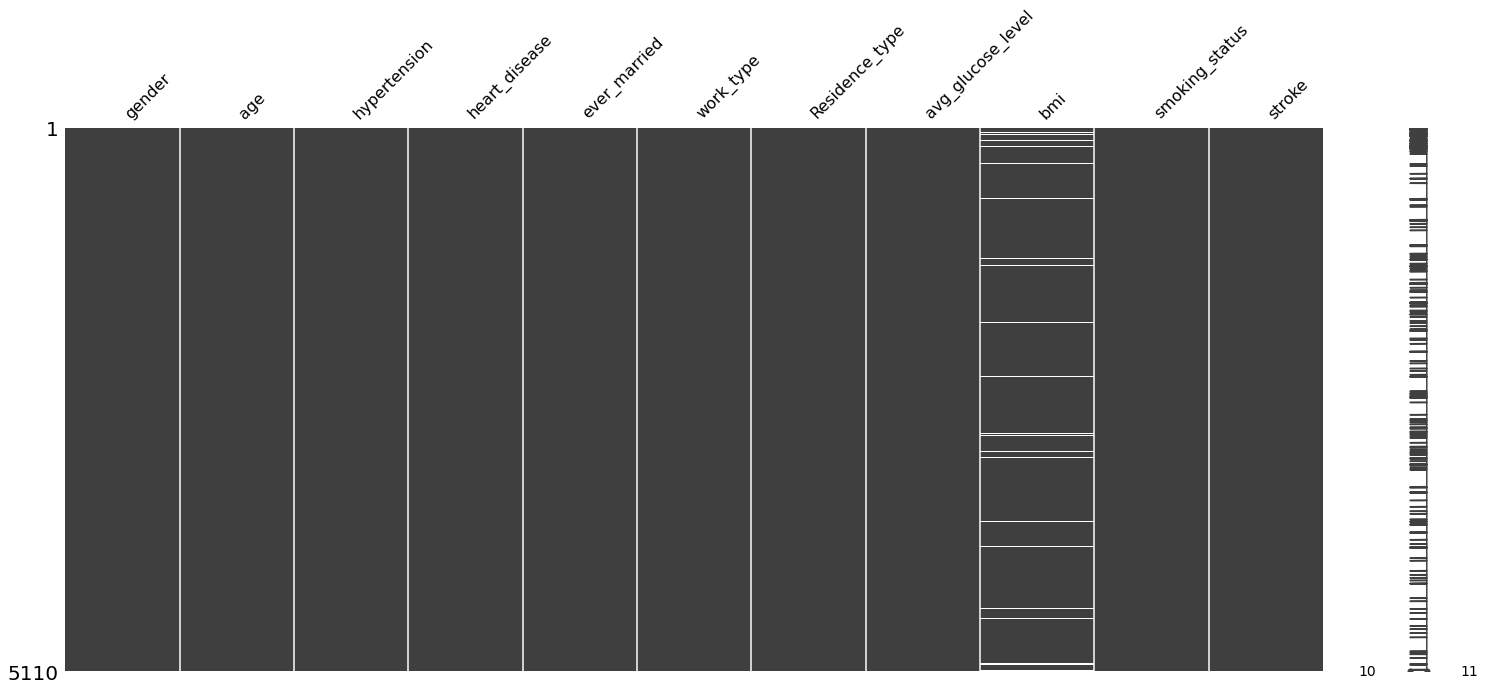

In [ ]:
msno.matrix(df);

We drop rows containing NaN values:

In [ ]:
# drop Nan values
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
# check the dataset
df.sample(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1722,Female,51.0,0,0,Yes,Private,Rural,83.30,34.0,formerly smoked,0
4241,Female,54.0,0,0,No,Private,Urban,85.07,21.9,Unknown,0
1605,Male,57.0,0,0,Yes,Private,Rural,70.16,25.8,formerly smoked,0


4909 samples remain in the dataset:

In [ ]:
# size of final dataset
df.shape

(4909, 11)

Now we have our dataset with 10 features plus 1 prediction target. 

Here we group the features based on type as discussed above:

In [ ]:
str_headers = ['gender',
               'ever_married',
               'work_type',
               'Residence_type',
               'smoking_status']
bin_headers = ['hypertension',
               'heart_disease']
num_headers = ['age',
               'avg_glucose_level',
               'bmi']
out_header  = ['stroke'] #binary

Once split into train and test sets, the numerical features will be scaled to zero mean and unit variance:

In [ ]:
def rescale(X_train_num, X_test_num):
    ss = StandardScaler()
    X_train_scale = ss.fit_transform(X_train_num)
    X_test_scale  = ss.transform(X_test_num)
    return X_train_scale,X_test_scale
#X_train_num,X_test_num = rescale(X_train_num,X_test_num)

One-hot encoding is not required as keras can interpret integers as categorical features. We also do not require dimensionality reduction given the relatively small number of features.

###Encode

This and subsequent sections modify code from the class notebook: https://github.com/eclarson/MachineLearningNotebooks/blob/master/10.%20Keras%20Wide%20and%20Deep.ipynb

We ultimately encode all categorical features (including crossed features) as integers and allow keras to handle the embedding.

We thus make the distinction between the string form and integer form of each categorical feature:

In [ ]:
# create string versions of binary features (for crossing step)
df['hypertension_str']  = df['hypertension'].map({0:'No hypertension',1:'Hypertension'})
df['heart_disease_str'] = df['heart_disease'].map({0:'No heart disease',1:'Heart disease'})
df['stroke_str'] = df['stroke'].map({0:'No stroke',1:'Stroke'})

In [ ]:
cat_headers = str_headers + ['hypertension_str','heart_disease_str']
cat_headers_ints = [x+'_int' for x in cat_headers]

Encode each categorical feature as integers:

In [ ]:
df_encode = df.copy()
encoders = dict() # save each encoder in dictionary

for col in cat_headers:
    df_encode[col] = df_encode[col].str.strip()
    encoders[col] = LabelEncoder() # save the encoder
    df_encode[col+'_int'] = encoders[col].fit_transform(df[col])

###Cross-product features

>*2) Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed).*

The number of disctinct classes across all categorical features is relatively small. For our Wide network to be sufficiently wide, we need multiple large crossings.

>We considered the following crossings:

>Personal life
* gender: 'gender'
* marriage: 'ever_married'
* work: 'work_type'
* residence: 'Residence_type'

>Health
* smoking: 'smoking_status'
* hypertension 'hypertension'
* heart disease: 'heart_disease'

>Full crossing (all categorical features)

Features pertaining to a person's various non-health choices were combined into a "Personal life" crossing. These do not immediately reflect health condition, i.e. the connection with stroke is less direct than the "Health" crossing.

The "Health" crossing was chosen to reflect the individual's own health status. There is a degree of control involved in these conditions (smoking, hypertension, heart disease) as a proper lifestyle can reduce or prevent these conditions.

Besides these two cross-product features, we would also combine all categorical features as another cross-product feature. After embedding (to sqrt(# combinations)), there were still very few nodes in the wide network. This large crossing more than doubled the width of the Wide network.



In [ ]:
personal_cross = ['gender','ever_married', 'work_type', 'Residence_type']
health_cross   = ['smoking_status', 'hypertension_str', 'heart_disease_str']

Create (integer encoded) crossed features:

In [ ]:
cross_columns = [personal_cross,health_cross,cat_headers]

# cross each set of columns in the list above
cross_headers = []
cross_headers_str = []

for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed = df_encode[cols_list].astype(str).apply(lambda x: '--'.join(x), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '--'.join(cols_list)
    
    # 2. encode as integers, stacking all possibilities
    enc.fit(X_crossed.to_numpy())

    # 3. Save into dataframe with new name
    df_encode[cross_col_name] = enc.transform(X_crossed)
    df_encode[cross_col_name+'--str'] = X_crossed

    # keep track of the new names of the crossed columns
    cross_headers.append(cross_col_name) 
    cross_headers_str.append(cross_col_name+'--str') 
    
cross_headers

['gender--ever_married--work_type--Residence_type',
 'smoking_status--hypertension_str--heart_disease_str',
 'gender--ever_married--work_type--Residence_type--smoking_status--hypertension_str--heart_disease_str']

Take a sample of the new crossed features (both encoded and unencoded):

In [ ]:
df_encode[cross_headers+cross_headers_str].sample(3)

,gender--ever_married--work_type--Residence_type,smoking_status--hypertension_str--heart_disease_str,gender--ever_married--work_type--Residence_type--smoking_status--hypertension_str--heart_disease_str,gender--ever_married--work_type--Residence_type--str,smoking_status--hypertension_str--heart_disease_str--str,gender--ever_married--work_type--Residence_type--smoking_status--hypertension_str--heart_disease_str--str
2206,29,9,236,Male--Yes--Private--Urban,never smoked--Hypertension--No heart disease,Male--Yes--Private--Urban--never smoked--Hyper...
2844,26,8,194,Male--Yes--Govt_job--Rural,never smoked--Hypertension--Heart disease,Male--Yes--Govt_job--Rural--never smoked--Hype...
2495,8,3,50,Female--No--children--Rural,Unknown--No hypertension--No heart disease,Female--No--children--Rural--Unknown--No hyper...


###Performance metric

>*3) Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*

We observe the data imbalance:

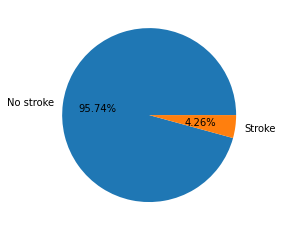

In [ ]:
unique,counts = np.unique(np.array(df.stroke_str),return_counts=True)
plt.pie(x=counts,labels=unique,autopct = lambda p:f'{p:.2f}%');

Only 4.26% of samples are positive (patient had a stroke).

Accuracy is a poor metric. A model predicting only negative would achieve almost 96% accuracy.

From our work with similar tasks (disease prediction, fraud detection), some natural alternatives would be precision, recall, F1 score (their harmonic mean), and AUC-ROC.

Considering the four categories of TP, TN, FP, and FN, we can use domain knowledge to help determine an appropriate metric.

In terms of the "falses" (FP and FN), FN is the worse of the two. False positives (incorrectly warning someone of impending stroke) would be inconvenient and a bit scary for the patient. False negatives would mean giving a patient the all-clear when their life is actually in danger.

Based on this, we choose the following metrics:

* Recall, which increases as false negatives decrease:
$$Recall = TP/(TP+FN)$$

* The F1-score is a popular choice for imbalanced classification. It can be written in another form as the harmonic mean of precision and recall:
$$F1 = 2*TP/(2*TP + FP + FN)$$

* AUC-ROC. Unlike Recall and F1, AUC-ROC is a "threshold-free" metric. Keras has an in-built decision threshold of 0.5, meaning any predicted value below 0.5 will be classed as negative and vice-versa. For severely imbalanced data, it is advisable to tune this threshold. For this lab, **we will not perform threshold moving**. Thus, a threshold-free metric is desirable. Average precision is an alternative.

Note some general ranges for AUC:
* 70-80%: acceptable
* 80-90%: excellent
* 90-100%: outstanding

These will be discussed when we reach the ROC curve later on.

###Divide the data

>*4) Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice.*

We have previously mentioned similarities between disease prediction and fraud detection, namely that they are often imbalanced binary classification problems. **However**, the practical methods for validation differ significantly.

Fraud detection is a bit of a moving target. Fraudulent activity evolves constantly to appear less fraudulent; a model that worked a year ago may be worthless today. Training and validation for fraud models may use rolling windows: The validation set may be chosen as the most recent batch of data, with the training set comprising several preceding batches. Data before that is not included.

Stroke is not an evolving condition in this sense. Provided the average american lifestyle has not significantly changed, data from 10 or more years ago would still be relevant. It would be realistic to continuously gather data into an ever-growing dataset. Once large enough, a simple train-test split would be acceptable.

---

Since our current dataset is *not* large, we will use **Stratified** KFolds. Stratification will preserve the ratio of classes, ensuring the presence of positive examples if the testing set is small.

Unlike StraitifiedShuffleSplit, StratifiedKFold guarantees that every sample will appear in both a training and test set. But either of these methods would be realistic for this application; The stratification is the key aspect, given the class imbalance. The argument is the same for fraud detection and other imbalanced binary tasks.

We will use **4 folds**; too many folds will result in very small testing sets and too few folds will be insufficient for validation. With 4 folds, we ensure our test sets have at least a 50 positive examples each. Metrics for each model will then be averaged across all splits.

Generate splits:

In [ ]:
def get_splits(random_state=None):
    y = df_encode.stroke.to_numpy()
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state)
    return [split for split in skf.split(np.zeros(len(y)),y)]
SPLITS = get_splits()

for split in SPLITS:
    print('train size:',len(split[0]),'\ttest size:',len(split[1]),'( positive:',(df.stroke[split[1]]==1).sum(),')')

train size: 3681 	test size: 1228 ( positive: 53 )
train size: 3682 	test size: 1227 ( positive: 52 )
train size: 3682 	test size: 1227 ( positive: 52 )
train size: 3682 	test size: 1227 ( positive: 52 )


Define several functions to retrieve train/test splits:

In [ ]:
def get_traintest(split):
    X = df_encode[cat_headers_ints].to_numpy()
    y = df_encode.stroke.to_numpy()

    itrain,itest = split
    X_train, X_test = X[itrain], X[itest]
    y_train, y_test = y[itrain], y[itest]
    return X_train,X_test,y_train,y_test

In [ ]:
def get_traintest_numcat(split):
    X_cat = df_encode[cat_headers_ints].to_numpy()
    X_num = df_encode[num_headers].to_numpy()
    y     = df_encode['stroke'].to_numpy()

    itrain,itest = split
    X_train_cat, X_test_cat = X_cat[itrain], X_cat[itest]
    X_train_num, X_test_num = X_num[itrain], X_num[itest]
    y_train, y_test = y[itrain], y[itest]
    return X_train_cat, X_train_num, X_test_cat, X_test_num, y_train, y_test

In [ ]:
def get_traintest_numcatcross(split):
    X_cat   = df_encode[cat_headers_ints].to_numpy()
    X_num   = df_encode[num_headers].to_numpy()
    X_cross = df_encode[cross_headers].to_numpy()
    y       = df_encode[out_header].to_numpy()

    itrain,itest = split
    X_train_cat, X_test_cat     = X_cat[itrain], X_cat[itest]
    X_train_num, X_test_num     = X_num[itrain], X_num[itest]
    X_train_cross, X_test_cross = X_cross[itrain], X_cross[itest]
    y_train, y_test             = y[itrain], y[itest]
    return X_train_cat, X_train_num, X_train_cross, X_test_cat, X_test_num, X_test_cross, y_train, y_test

### Upsampling

*Reference*: https://towardsdatascience.com/heres-what-i-ve-learnt-about-sklearn-resample-ab735ae1abc4

Given the imbalance, we use upsampling on the training sets. We are primarily concerned with detecting positives, so we increase the amount of positives we show to our model during training.

Define the upsampling function:

In [ ]:
def upsample(inputs_train,y_train):
    y_train = y_train.flatten()
    mini = y_train==1
    maji = y_train==0
    num_neg = np.sum(maji)
    upsampled = resample(*[input[mini] for input in inputs_train], y_train[mini],
                         n_samples=num_neg)
    
    inputs_up = [np.vstack((input[maji],upsampled[i])) for i,input in enumerate(inputs_train)]
    y_up      = np.hstack((y_train[maji],upsampled[-1]))
    return inputs_up, y_up

Example of usage:

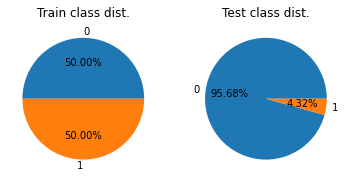

In [ ]:
X_train,X_test,y_train,y_test = get_traintest(SPLITS[0])

#upsample training data
X_train,y_train = upsample([X_train],y_train)

fig,ax = plt.subplots(1,2)
unique,counts = np.unique(y_train,return_counts=True)
ax[0].pie(x=counts,labels=unique,autopct = lambda p:f'{p:.2f}%');
ax[0].set_title('Train class dist.');
unique,counts = np.unique(y_test,return_counts=True)
ax[1].pie(x=counts,labels=unique,autopct = lambda p:f'{p:.2f}%');
ax[1].set_title('Test class dist.');

### Binary Focal Loss

Reference: https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.binary_focal_loss.html#focal_loss.binary_focal_loss

For mathematical description, see https://focal-loss.readthedocs.io/en/latest/generated/focal_loss.binary_focal_loss.html#id2

Focal losses can be used on imbalanced data to increase the penalty for misclassifying the minority class.

Here we use binary focal loss. There are various hyperparameters to choose here, but we concern ourselves with $\gamma$:

In [ ]:
BinaryFocalLoss(gamma=1)

$\gamma$ is the *focusing parameter*. It is responsible for the relative increase in penalty for misclassifying the minority class.

When $\gamma=0$, these is no penalty increase and we recover the standard binary cross entropy.

Higher values correspond to a higher relative penalty. We choose $\gamma=1$ for our models, without performing optimization on this parameter.

###Early stopping

ROC-AUC is the key metric we want to improve (Described in performance metrics section). It is also a more stable metric than validation recall or loss during training. We thus use validation AUC score as an early stopping condition:

In [ ]:
tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

The patience value of 20 indicates that the model will terminate training once the validation AUC score has not improved for 20 epochs. This value was chosen heuristically.

###McNemar testing for comparing models

To statistically compare two models, we use a McNemar test to first determine whether they are statistically different.

With each model using the same set of folds (generated by StratifiedKFold), we can compare models on each fold and calculate an average $\chi$ statistic across all folds.

If the average $\chi^2$ exceeds a critical value, the models are different with specified confidence. We choose 95% confidence, for which the critical value (1 DOF) of $\chi^2$ is 3.841.

$\chi^2$ is calculated by
$$\chi^2=\frac{(|B-C|-1)^2}{B+C}$$
where A,B,C,D are the entries of McNemar matrix.

In [ ]:
def mcnemar_test(y_preds1,y_preds2,y_tests,name1='model1',name2='model2'):
    nfolds = len(y_tests)
    print('McNemar test: '+name1,'vs',name2)

    y_tests = [t.flatten() for t in y_tests]
    y_hats1 = [np.round(p).flatten() for p in y_preds1]
    y_hats2 = [np.round(p).flatten() for p in y_preds2]

    AND = np.logical_and
    NOT = np.logical_not
    print('\n    A   B   C   D   chi^2')

    chi2 = np.zeros(nfolds)
    A = np.zeros(nfolds,int)
    B = np.zeros(nfolds,int)
    C = np.zeros(nfolds,int)
    D = np.zeros(nfolds,int)
    for k in range(nfolds):
        m1_correct = y_hats1[k]==y_tests[k]
        m2_correct = y_hats2[k]==y_tests[k]

        A[k] = AND(m1_correct,m2_correct).sum()
        B[k] = AND(m1_correct,NOT(m2_correct)).sum()
        C[k] = AND(NOT(m1_correct),m2_correct).sum()
        D[k] = AND(NOT(m1_correct),NOT(m2_correct)).sum()

        chi2[k] = (np.abs(B[k]-C[k])-1)**2 / (B[k]+C[k])

        print('k='+str(k),A[k],B[k],C[k],D[k],chi2[k].round(4))

    THRESH = 3.841 # chi^2 critical value for 95% confidence

    mean_chi2 = np.mean(chi2)
    print('\nMean chi^2:',mean_chi2.round(4), '( Critical value',THRESH,')')

    if mean_chi2 >= THRESH:
        print('>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<')
    else:
        print('>>> Cannot conclude statistical difference! <<<')

    # Compare models by mean value of B and C
    print('\nMean B:',np.mean(B))
    print('Mean C:',np.mean(C))
    if np.mean(B)>np.mean(C):
        print('>>> '+name1+' is superior (B>C) <<<')
    else:
        print('>>> '+name2+' is superior (C>B) <<<')

mcnemar_test(y_preds_Dfinal,y_preds_WDfinal,y_tests_final,'Deep-only','Best W&D')

McNemar test: Deep-only vs Best W&D

    A   B   C   D   chi^2
k=0 894 12 55 267 26.3284
k=1 845 17 56 309 19.7808
k=2 830 22 94 281 43.4569
k=3 839 18 68 302 27.9186

Mean chi^2: 29.3712 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 17.25
Mean C: 68.25
>>> Best W&D is superior (C>B) <<<


In this example, "superior" could simply mean it is better at predicting the majority class, since B and C are based on quantity. The "inferior" model could be better at predicting the minority class, and thus have higher scores in other metrics.

###Printing function

In [ ]:
def show_perf(histories,y_preds,y_tests,title=None,confusion=True):

    y_hats = [np.round(p) for p in y_preds]
    print(str(len(histories))+'-fold validation metrics:',)

    # Get mean metrics across folds
    mean_auc = np.mean([mt.roc_auc_score(y_test,y_hat) for y_test,y_hat in zip(y_tests,y_preds)])
    mean_rec = np.mean([mt.recall_score(y_test,y_hat) for y_test,y_hat in zip(y_tests,y_hats)])
    mean_f1  = np.mean([mt.f1_score(y_test,y_hat) for y_test,y_hat in zip(y_tests,y_hats)])

    print('Mean ROC-AUC: ', mean_auc.round(4))
    print('Mean Recall:  ', mean_rec.round(4))
    print('Mean F1-score:', mean_f1.round(4))

    MA = 8 # Moving average length

    # Plot metrics for train sets in blue, test sets in orange
    fig,ax = plt.subplots(1,3,sharex=True,figsize=(15,5))
    for i,h in enumerate(histories):
        ax[0].plot(h.history['auc'],      'tab:blue',   label='auc' if i==0 else None);
        ax[0].plot(h.history['val_auc'],  'tab:orange', label='val_auc' if i==0 else None);
        ax[1].plot(h.history['rec'],      'tab:blue',   label='rec' if i==0 else None);
        ax[2].plot(h.history['loss'],     'tab:blue',   label='loss' if i==0 else None);

        # Plot validation recall and loss using moving averages (very noisy otherwise)
        ax[1].plot(np.convolve(h.history['val_rec'], np.ones(MA)/MA, mode='valid'), 'tab:orange', label='val_rec_MA'+str(MA) if i==0 else None);
        ax[2].plot(np.convolve(h.history['val_loss'], np.ones(MA)/MA, mode='valid'), 'tab:orange', label='val_loss_MA'+str(MA) if i==0 else None);

    ax[0].plot(ax[0].get_xlim(),[mean_auc]*2,'tab:orange',linestyle='dashed',label='mean val_auc')
    ax[1].plot(ax[1].get_xlim(),[mean_rec]*2,'tab:orange',linestyle='dashed',label='mean val_rec')
    
    ax[0].set_title('AUC')
    ax[1].set_title('Recall')
    ax[2].set_title('Loss')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.suptitle(title)

    # Show confusion matrices
    if confusion:
        print('Confusion matrices:')
        for y_test,y_hat in zip(y_tests,y_hats):
            print(mt.confusion_matrix(y_test,y_hat))

---

##Modeling

>*5) Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.*

###Baseline MLP

In [ ]:
keras.__version__

'2.7.0'

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


We begin by creating a simple MLP that treats our encoded data purely as integers. We use a mix of relu and tanh activations, with the stochastic gradient descent (sgd) optimizer. We use binary focal loss as discussed, and track the Recall and AUC metrics through the epochs.

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 7)]               0         
                                                                 
 dense_44 (Dense)            (None, 50)                400       
                                                                 
 dense_45 (Dense)            (None, 25)                1275      
                                                                 
 dense_46 (Dense)            (None, 10)                260       
                                                                 
 dense_47 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,946
Trainable params: 1,946
Non-trainable params: 0
_________________________________________________________________


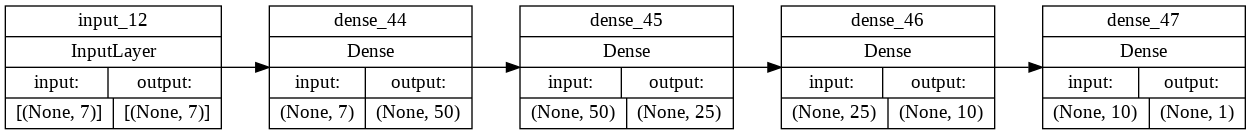

In [ ]:
#=== Construct Dense network (no encoding)===
def new_MLP_1():
    input_tensor = Input(shape=(len(cat_headers_ints),))

    x = Dense(units=50, activation='relu')(input_tensor)
    x = Dense(units=25, activation='relu')(x)
    x = Dense(units=10, activation='tanh')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    model.compile(optimizer='sgd',
                  loss=BinaryFocalLoss(gamma=1),
                  metrics=[Recall(name='rec'),
                           AUC(name='auc')])
    return model

model = new_MLP_1()
model.summary()
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Upsample data and train the model.

We use an early stopping condition based on the validation AUC:

In [ ]:
%%time
# Initialize history
histories = [None]*len(SPLITS)

# Initialize predictions
y_preds = [None]*len(SPLITS)
y_tests = [None]*len(SPLITS)

for i,split in enumerate(SPLITS):
    print('Training fold',i+1,'/',len(SPLITS),'...')

    # Retrieve an untrained model
    model = new_MLP_1()

    # Get train/test split (from KFold)
    X_train_cat,X_test_cat,y_train,y_test = get_traintest(split)

    # Upsample training data
    X_train_cat,y_train = upsample([X_train_cat],y_train)

    # Define early stopping
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

    # Fit model
    histories[i] = model.fit(X_train_cat, y_train, epochs=200, batch_size=50, verbose=0,
                           validation_data=[X_test_cat, y_test],
                           callbacks=[earlystop])
    
    # Record predictions
    y_preds[i] = model.predict(X_test_cat) # sigmoid output probabilities
    y_tests[i] = y_test

Training fold 1 / 4 ...
Training fold 2 / 4 ...
Training fold 3 / 4 ...
Training fold 4 / 4 ...
CPU times: user 1min, sys: 2.94 s, total: 1min 3s
Wall time: 51.6 s


Even without a proper encoding, we notice decent recall for positive cases:

In [ ]:
histories[0].history.keys()

dict_keys(['loss', 'rec', 'auc', 'val_loss', 'val_rec', 'val_auc'])

4-fold validation metrics:
Mean ROC-AUC:  0.726
Mean Recall:   0.632
Mean F1-score: 0.1454
Confusion matrices:
[[810 365]
 [ 24  29]]
[[751 424]
 [ 18  34]]
[[894 281]
 [ 21  31]]
[[752 423]
 [ 14  38]]


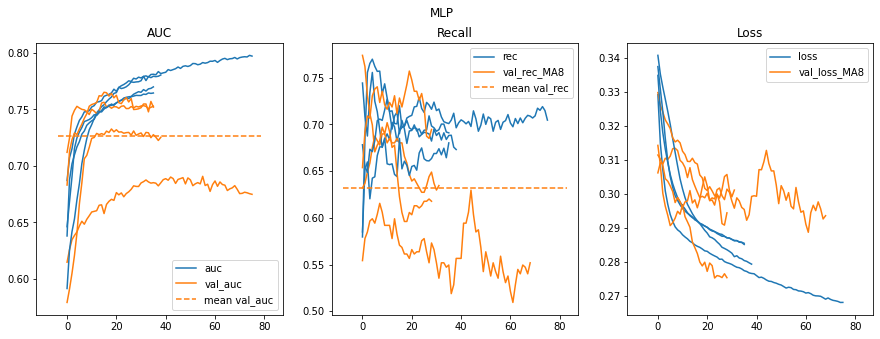

In [ ]:
show_perf(histories,y_preds,y_tests,title='MLP')

---

###Deep-only network with embedding

Let's make a proper Deep network with encoded labels:

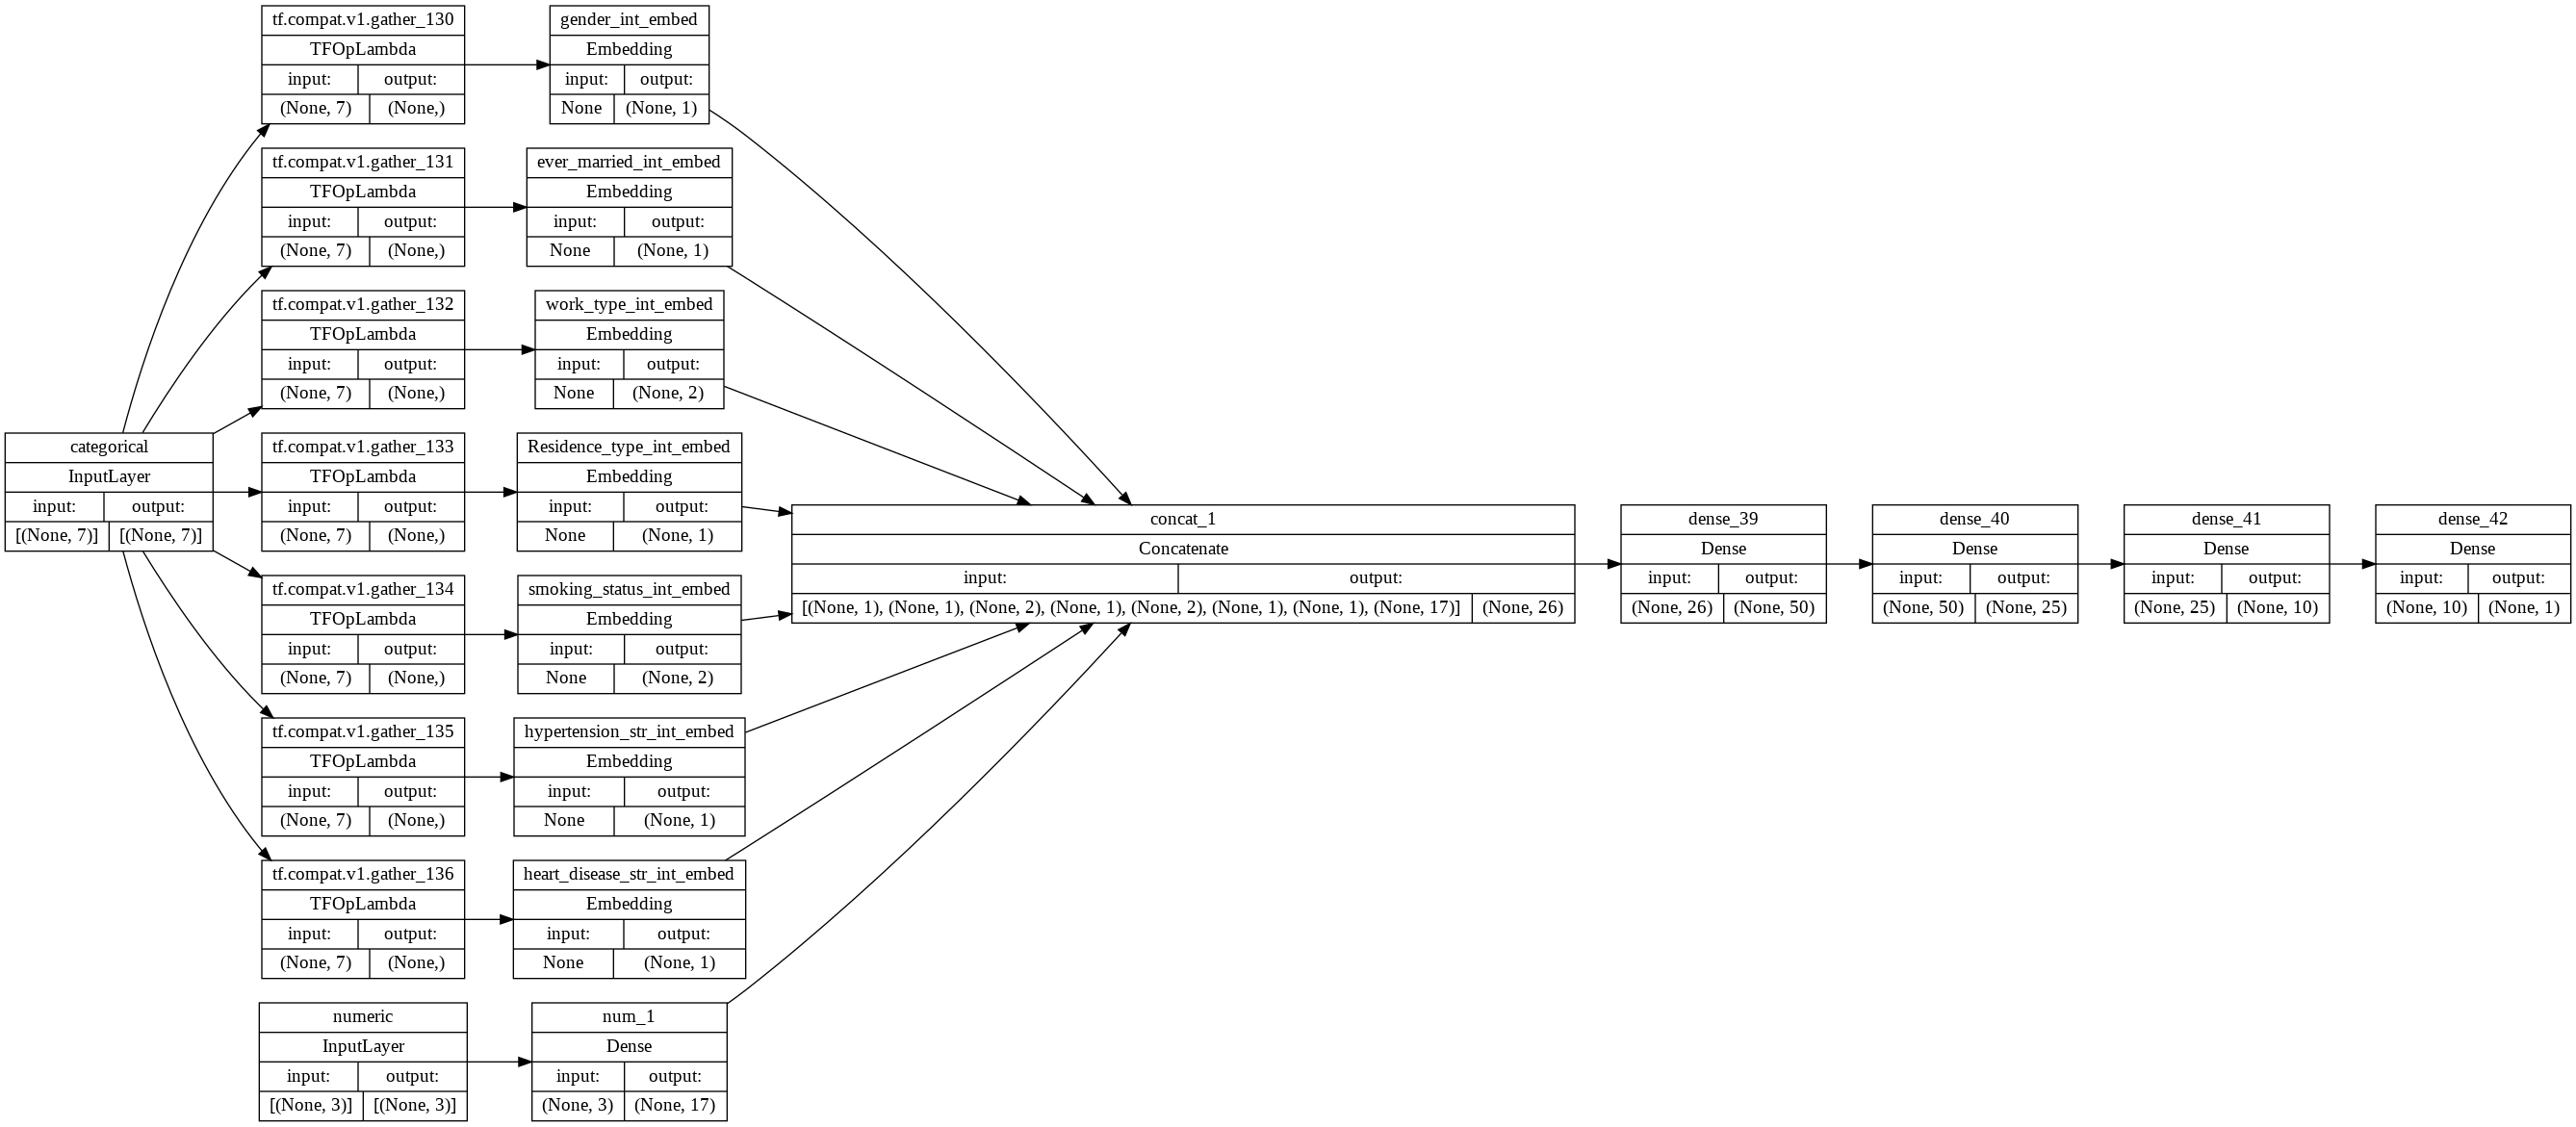

In [ ]:
#=== Construct Dense network (no encoding)===
def new_Deep_1():
    embed_branches = []
    all_branch_outputs = []

    input_branch = Input(shape=(len(cat_headers_ints),), 
                        dtype='int64', 
                        name='categorical')

    # for each categorical variable
    for i,col in enumerate(cat_headers_ints):
        
        N = max(df_encode[col])+1 
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_branch, i, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=int(np.sqrt(N)), 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs in list to concatenate later
        all_branch_outputs.append(x)

    # include numerical data
    inputs_num = Input(shape=(len(num_headers),), name='numeric')
    x_dense = Dense(units=17, activation='relu', name='num_1')(inputs_num)
        
    all_branch_outputs.append(x_dense)
    
    # now concatenate the outputs and add a fully connected layer
    x = concatenate(all_branch_outputs, name='concat_1')
    x = Dense(units=50, activation='relu')(x)
    x = Dense(units=25, activation='relu')(x)
    x = Dense(units=10, activation='tanh')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_branch,inputs_num], outputs=predictions)

    model.compile(optimizer='sgd',
                loss=BinaryFocalLoss(gamma=1),
                metrics=[Recall(name='rec'),
                        AUC(name='auc')])
    return model

model = new_Deep_1()
# model.summary()
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

Train on each fold:

In [ ]:
%%time
# Initialize history
histories_deep = [None]*len(SPLITS)

# Initialize predictions
y_preds_deep = [None]*len(SPLITS)
y_tests_deep = [None]*len(SPLITS)

for i,split in enumerate(SPLITS):
    print('Training fold',i+1,'/',len(SPLITS),'...')

    # Retrieve an untrained model
    model = new_Deep_1()

    # Get train/test split (from KFold)
    X_train_cat,X_train_num,X_test_cat,X_test_num,y_train,y_test = get_traintest_numcat(split)

    # Upsample training data
    (X_train_cat,X_train_num),y_train = upsample([X_train_cat,X_train_num],y_train)

    # Rescale numerical
    X_train_num,X_test_num = rescale(X_train_num,X_test_num)

    # Define early stopping
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

    # Fit model
    histories_deep[i] = model.fit((X_train_cat,X_train_num), y_train, epochs=200, batch_size=50, verbose=0,
                            validation_data=[(X_test_cat,X_test_num), y_test],
                            callbacks=[earlystop])
    
    # Record predictions
    y_preds_deep[i] = model.predict((X_test_cat,X_test_num)) # sigmoid output probabilities
    y_tests_deep[i] = y_test

Training fold 1 / 4 ...
Training fold 2 / 4 ...
Training fold 3 / 4 ...
Training fold 4 / 4 ...
CPU times: user 1min 10s, sys: 3.32 s, total: 1min 14s
Wall time: 2min 7s


Show results:

4-fold validation metrics:
Mean ROC-AUC:  0.8342
Mean Recall:   0.799
Mean F1-score: 0.1997
Confusion matrices:
[[843 332]
 [ 10  43]]
[[873 302]
 [ 12  40]]
[[824 351]
 [  9  43]]
[[862 313]
 [ 11  41]]


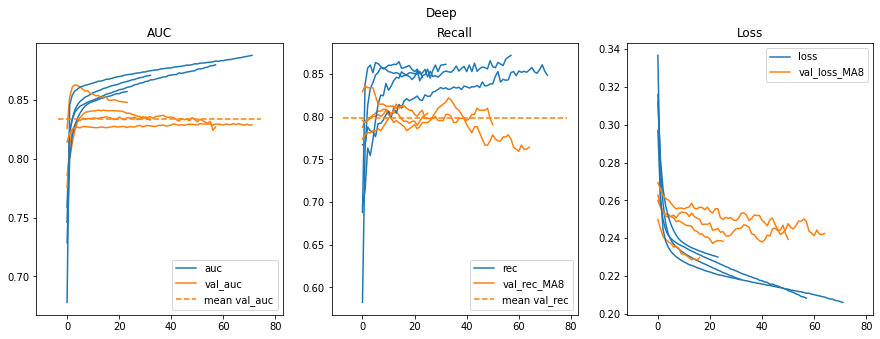

In [ ]:
show_perf(histories_deep,y_preds_deep,y_tests_deep,title='Deep')

The metrics are significantly improved over the baseline MLP. WE can perform a McNemar test to establish difference:

In [ ]:
mcnemar_test(y_preds,y_preds_deep,y_tests,'MLP','Deep')

McNemar test: MLP vs Deep

    A   B   C   D   chi^2
k=0 697 142 189 200 6.3927
k=1 659 126 254 188 42.4447
k=2 745 180 122 180 10.7583
k=3 666 124 237 200 34.7479

Mean chi^2: 23.5859 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 143.0
Mean C: 200.5
>>> Deep is superior (C>B) <<<


---

###Wide&Deep network with crossed features

For the sake of time we skip over doing a Wide-only network.

We define a function to create various types of W&D networks:

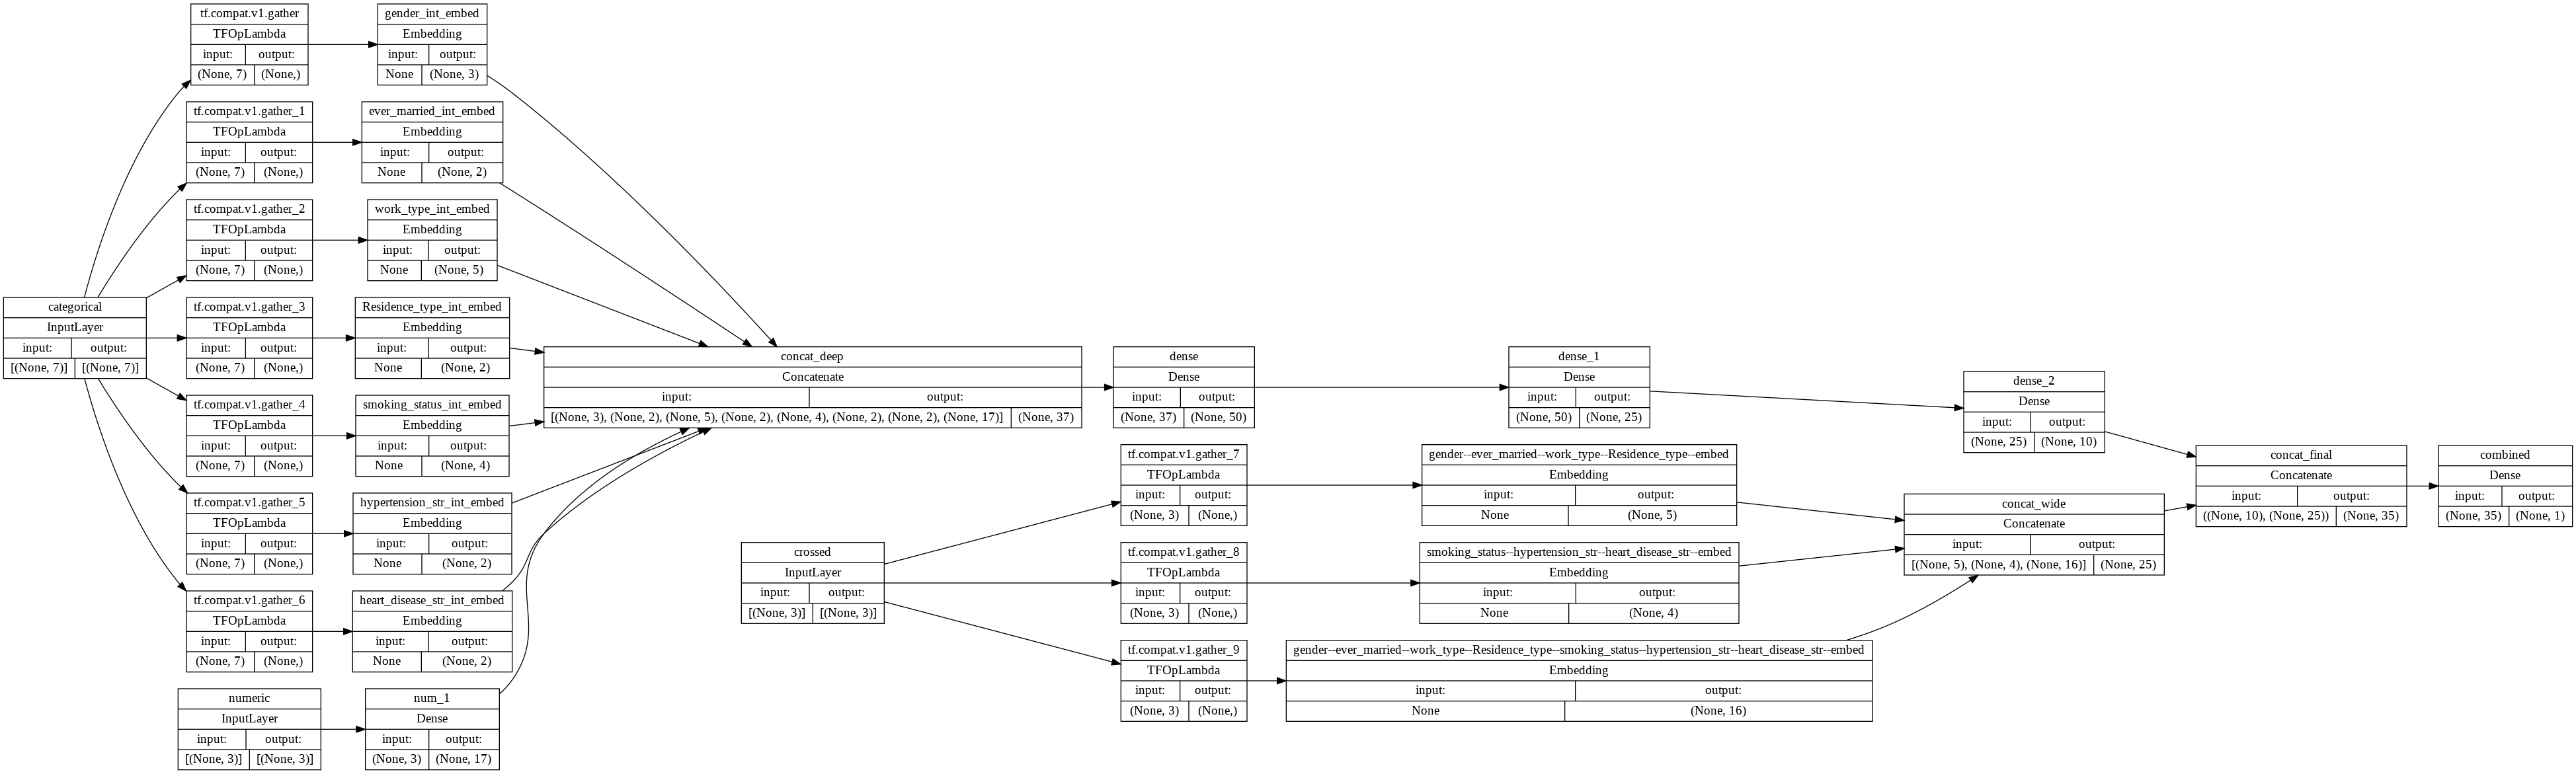

In [ ]:
#=== Construct Dense network (no encoding)===
def new_Wide(deep_shape = [50,25,10],
             loss       = BinaryFocalLoss(gamma=1),
             optimizer  = 'sgd',
             activation = 'relu'):
    #=== DEEP ===
    #>>Categorical<<
    embed_branches = []
    deep_branch_outputs = []

    # feed in the entire matrix of categorical variables
    input_cat = Input(shape=(len(cat_headers_ints),), 
                      dtype='int64', 
                      name='categorical')

    # encode each categorical variable
    for idx,col in enumerate(cat_headers_ints):
        N = max(df_encode[col])+1
        x = tf.gather(input_cat, idx, axis=1)
        x = Embedding(input_dim=N, 
                    output_dim=N,#int(np.sqrt(N)), 
                    input_length=1, name=col+'_embed')(x)
        deep_branch_outputs.append(x)

    #>>Numerical<<
    input_num = Input(shape=(len(num_headers),), name='numeric')
    x_dense = Dense(units=17, activation=activation, name='num_1')(input_num)
        
    deep_branch_outputs.append(x_dense)

    x = concatenate(deep_branch_outputs, name='concat_deep')
    for size in deep_shape:
        x = Dense(units=size, activation=activation,kernel_initializer='he_uniform')(x)
    deep_branch = x

    #=== WIDE ===
    #>>Crossed<<
    cross_outputs = [] # this is where we will keep track of output of each branch

    input_cross = Input(shape=(len(cross_headers),), dtype='int64', name='crossed')

    # encode each cross variable
    for idx,col in enumerate(cross_headers):
        N = max(df_encode[col])+1
        x = tf.gather(input_cross, idx, axis=1)
        x = Embedding(input_dim=N, 
                    output_dim=int(np.sqrt(N)), 
                    input_length=1, name=col+'--embed')(x)
        cross_outputs.append(x)
        
    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(cross_outputs, name='concat_wide')
    # wide_branch = Dense(units=1,activation='sigmoid', name='combined')(wide_branch)

    #=== COMBINE WIDE AND DEEP ===
    x = concatenate((deep_branch,wide_branch), name='concat_final')
    final_branch = Dense(units=1,activation='sigmoid', name='combined')(x)

    model = Model(inputs=[input_cat,input_num,input_cross], outputs=final_branch)

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[Recall(name='rec'),
                           AUC(name='auc')])
        return model

# Plot model
model = new_Wide()
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

We choose to create three W&D models that differ in the hyperparameter $\gamma$ of the BinaryFocalLoss loss function. Note that $\gamma=0$ is a special case of *binary focal loss* equivalent to *binary cross entropy*.

In [ ]:
%%time
histories_WD = [[None]*len(SPLITS),[None]*len(SPLITS),[None]*len(SPLITS)]

y_preds_WD = [[None]*len(SPLITS),[None]*len(SPLITS),[None]*len(SPLITS)]
y_tests_WD = [None]*len(SPLITS)

# Choose parameters for each W&D network
model_params = ([[50,25,10], BinaryFocalLoss(gamma=0), 'sgd', 'relu'],
                [[50,25,10], BinaryFocalLoss(gamma=1), 'sgd', 'relu'],
                [[50,25,10], BinaryFocalLoss(gamma=2), 'sgd', 'relu'])

for m,params in enumerate(model_params):
    print('Model',m+1)
    for i,split in enumerate(SPLITS):
        print('\tTraining fold',i+1,'/',len(SPLITS),'...')

        # Retrieve an untrained model
        model = new_Wide(*model_params[m])

        # Get train/test split (from KFold)
        X_train_cat,X_train_num,X_train_cross,X_test_cat,X_test_num,X_test_cross,y_train,y_test = get_traintest_numcatcross(split)

        # Upsample training data
        (X_train_cat,X_train_num,X_train_cross),y_train = upsample([X_train_cat,X_train_num,X_train_cross],y_train)

        # Rescale numerical
        X_train_num,X_test_num = rescale(X_train_num,X_test_num)

        # Define early stopping
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

        # Fit model
        histories_WD[m][i] = model.fit((X_train_cat,X_train_num,X_train_cross), y_train, epochs=200, batch_size=50, verbose=0,
                                      validation_data=[(X_test_cat,X_test_num,X_test_cross), y_test],
                                      callbacks=[earlystop])
        
        # Record predictions
        y_preds_WD[m][i] = model.predict((X_test_cat,X_test_num,X_test_cross)) # sigmoid output probabilities
        y_tests_WD[i] = y_test

Model 1
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
Model 2
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
Model 3
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
CPU times: user 3min 14s, sys: 8.11 s, total: 3min 22s
Wall time: 3min 5s


####Performance of the 3 W&D models

We obtain and plot the training histories of the three models. Confusion matrices are suppressed for clarity; the following McNemar tests show similar information.

4-fold validation metrics:
Mean ROC-AUC:  0.8359
Mean Recall:   0.775
Mean F1-score: 0.2052


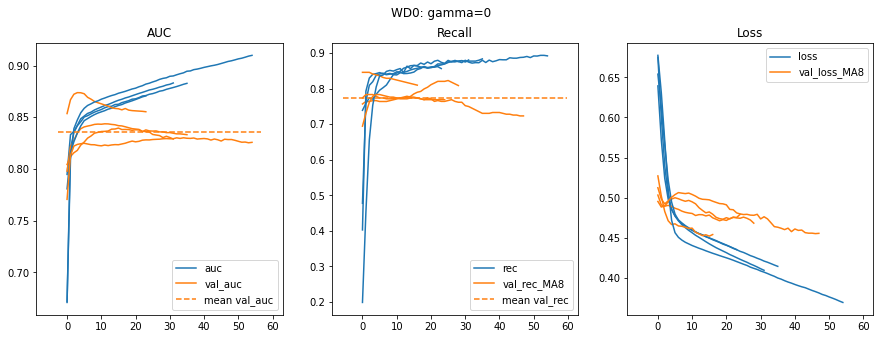

In [ ]:
show_perf(histories_WD[0],y_preds_WD[0],y_tests,title='WD0: gamma=0',confusion=False)

4-fold validation metrics:
Mean ROC-AUC:  0.8336
Mean Recall:   0.7751
Mean F1-score: 0.205


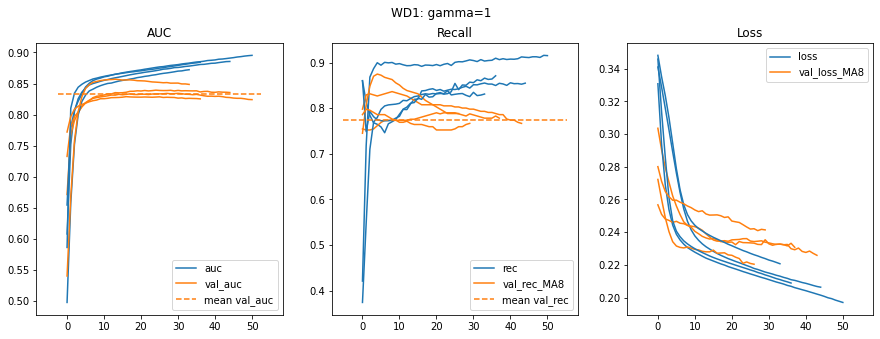

In [ ]:
show_perf(histories_WD[1],y_preds_WD[1],y_tests,title='WD1: gamma=1',confusion=False)

4-fold validation metrics:
Mean ROC-AUC:  0.8388
Mean Recall:   0.7609
Mean F1-score: 0.2041


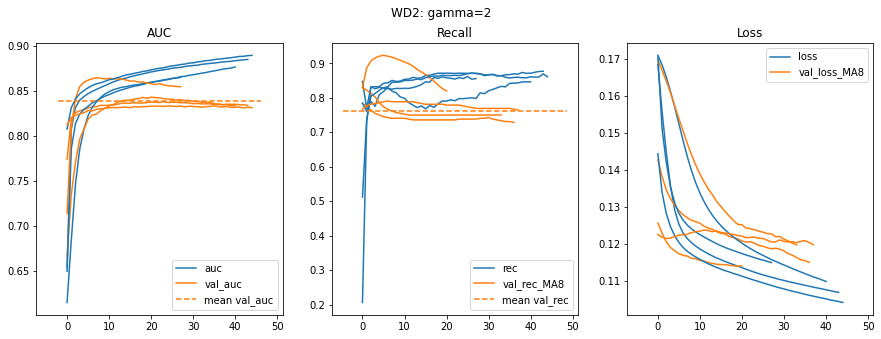

In [ ]:
show_perf(histories_WD[2],y_preds_WD[2],y_tests,title='WD2: gamma=2',confusion=False)

####Pairwise McNemar tests on the 3 W&D models

Based on our chosen metrics (ROC-AUC, recall, F1-score), these models have very similar performance. We can concretely establish whether they are differenct by pariwise McNemar tests:

In [ ]:
mcnemar_test(y_preds_WD[0],y_preds_WD[1],y_testsWD,'WD0','WD1')

McNemar test: WD0 vs WD1

    A   B   C   D   chi^2
k=0 877 22 27 302 0.3265
k=1 876 36 41 274 0.2078
k=2 875 20 43 289 7.6825
k=3 884 62 29 252 11.2527

Mean chi^2: 4.8674 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 35.0
Mean C: 35.0
>>> WD1 is superior (C>B) <<<


In [ ]:
mcnemar_test(y_preds_WD[1],y_preds_WD[2],y_testsWD,'WD1','WD2')

McNemar test: WD1 vs WD2

    A   B   C   D   chi^2
k=0 874 30 39 285 0.9275
k=1 883 34 55 255 4.4944
k=2 873 45 23 286 6.4853
k=3 893 20 28 286 1.0208

Mean chi^2: 3.232 ( Critical value 3.841 )
>>> Cannot conclude statistical difference! <<<

Mean B: 32.25
Mean C: 36.25
>>> WD2 is superior (C>B) <<<


In [ ]:
mcnemar_test(y_preds_WD[0],y_preds_WD[2],y_testsWD,'WD0','WD2')

McNemar test: WD0 vs WD2

    A   B   C   D   chi^2
k=0 872 27 41 288 2.4853
k=1 882 30 56 259 7.2674
k=2 858 37 38 294 0.0
k=3 894 52 27 254 7.2911

Mean chi^2: 4.261 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 36.5
Mean C: 40.5
>>> WD2 is superior (C>B) <<<


Note that we *cannot* conclude that the last two models ($\gamma=1,2$) are statistically different. However, as mentioned, $\gamma=0$ reduces *binary focal loss* to *binary cross entropy,* which eliminates the increased penalty on the minority class altogether. We find that the first model ($\gamma=0$) is statistically different from the others with nonzero $\gamma$.

We notice from the comparisons that $\gamma=2$ is marginally superior to the others, based on the values B,C from the McNemar test matrix.

###Generalization performance of Deep branch

This time, we vary the shape of the deep branches. For this we have chosen "Large" "Medium" and "Small" networks, each using the classic halving of node numbers at each layer:

In [ ]:
%%time
histories_WDgen = [[None]*len(SPLITS),[None]*len(SPLITS),[None]*len(SPLITS)]

y_preds_WDgen = [[None]*len(SPLITS),[None]*len(SPLITS),[None]*len(SPLITS)]
y_tests_WDgen = [None]*len(SPLITS)

# Choose parameters for each W&D network
model_params = ([[100,50,25,10], BinaryFocalLoss(gamma=1), 'sgd', 'relu'],
                [[50,25,10],     BinaryFocalLoss(gamma=1), 'sgd', 'relu'],
                [[10,5],         BinaryFocalLoss(gamma=1), 'sgd', 'relu'])

for m,params in enumerate(model_params):
    print('Model',m+1)
    for i,split in enumerate(SPLITS):
        print('\tTraining fold',i+1,'/',len(SPLITS),'...')

        # Retrieve an untrained model
        model = new_Wide(*model_params[m])

        # Get train/test split (from KFold)
        X_train_cat,X_train_num,X_train_cross,X_test_cat,X_test_num,X_test_cross,y_train,y_test = get_traintest_numcatcross(split)

        # Upsample training data
        (X_train_cat,X_train_num,X_train_cross),y_train = upsample([X_train_cat,X_train_num,X_train_cross],y_train)

        # Rescale numerical
        X_train_num,X_test_num = rescale(X_train_num,X_test_num)

        # Define early stopping
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

        # Fit model
        histories_WDgen[m][i] = model.fit((X_train_cat,X_train_num,X_train_cross), y_train, epochs=200, batch_size=50, verbose=0,
                                      validation_data=[(X_test_cat,X_test_num,X_test_cross), y_test],
                                      callbacks=[earlystop])
        
        # Record predictions
        y_preds_WDgen[m][i] = model.predict((X_test_cat,X_test_num,X_test_cross)) # sigmoid output probabilities
        y_tests_WDgen[i] = y_test

Model 1
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
Model 2
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
Model 3
	Training fold 1 / 4 ...
	Training fold 2 / 4 ...
	Training fold 3 / 4 ...
	Training fold 4 / 4 ...
CPU times: user 4min 3s, sys: 10.8 s, total: 4min 14s
Wall time: 4min 17s


####Performance comparison of Large, Medium, and Small  deep branches

Based on our chosen metrics, it is not clear whether the three models are different. They perform very similarly in terms of our three chosen metrics, with the smallest network having marginally better ROC-AUC and Recall, which are both desirable.

4-fold validation metrics:
Mean ROC-AUC:  0.8274
Mean Recall:   0.7607
Mean F1-score: 0.2066


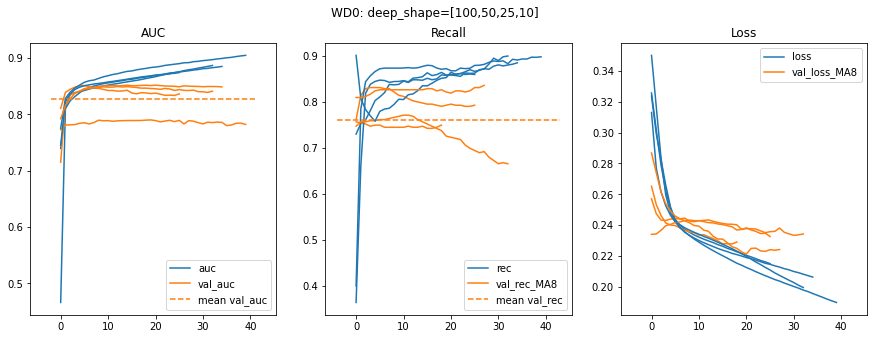

In [ ]:
show_perf(histories_WDgen[0],y_preds_WDgen[0],y_tests_WDgen,title='WDgen0: deep_shape=[100,50,25,10]',confusion=False)

4-fold validation metrics:
Mean ROC-AUC:  0.8333
Mean Recall:   0.7561
Mean F1-score: 0.2044


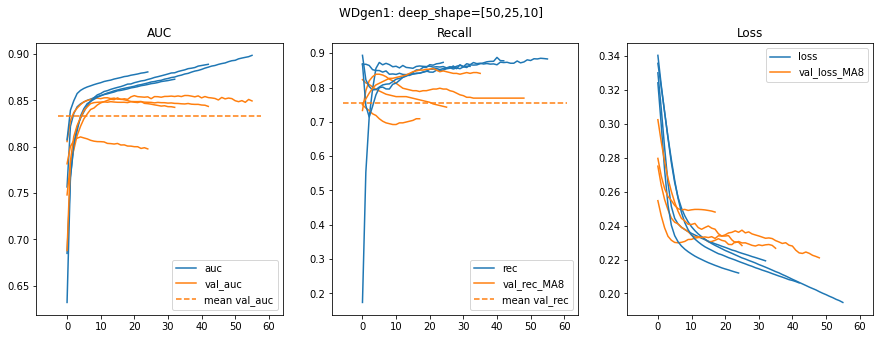

In [ ]:
show_perf(histories_WDgen[1],y_preds_WDgen[1],y_tests_WDgen,title='WDgen1: deep_shape=[50,25,10]',confusion=False)

4-fold validation metrics:
Mean ROC-AUC:  0.837
Mean Recall:   0.7897
Mean F1-score: 0.2049


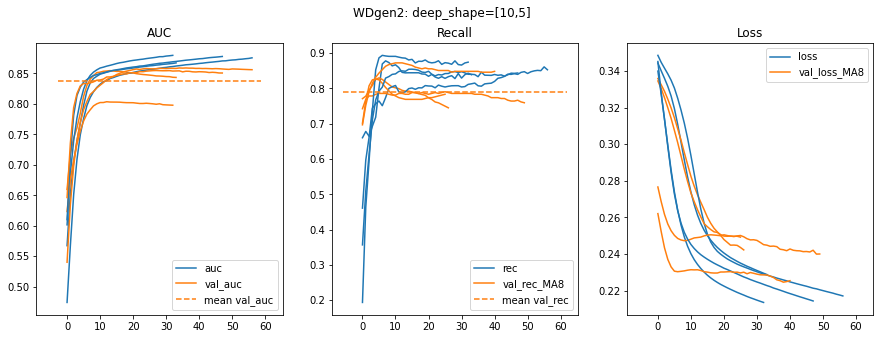

In [ ]:
show_perf(histories_WDgen[2],y_preds_WDgen[2],y_tests_WDgen,title='WDgen2: deep_shape=[10,5]',confusion=False)

####Pairwise McNemar tests on Large, Medium, and Small  deep branches

To establish difference, we perform pairwise McNemar tests:

In [ ]:
mcnemar_test(y_preds_WDgen[0],y_preds_WDgen[1],y_tests_WDgen,'WDgen0','WDgen1')

McNemar test: WDgen0 vs WDgen1

    A   B   C   D   chi^2
k=0 888 19 42 279 7.9344
k=1 911 33 31 252 0.0156
k=2 847 74 35 271 13.2477
k=3 881 35 38 273 0.0548

Mean chi^2: 5.3131 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 40.25
Mean C: 36.5
>>> WDgen0 is superior (B>C) <<<


In [ ]:
mcnemar_test(y_preds_WDgen[1],y_preds_WDgen[2],y_tests_WDgen,'WDgen1','WDgen2')

McNemar test: WDgen1 vs WDgen2

    A   B   C   D   chi^2
k=0 904 26 30 268 0.1607
k=1 897 45 25 260 5.1571
k=2 847 35 30 315 0.2462
k=3 872 47 21 287 9.1912

Mean chi^2: 3.6888 ( Critical value 3.841 )
>>> Cannot conclude statistical difference! <<<

Mean B: 38.25
Mean C: 26.5
>>> WDgen1 is superior (B>C) <<<


In [ ]:
mcnemar_test(y_preds_WDgen[0],y_preds_WDgen[2],y_tests_WDgen,'WDgen0','WDgen2')

McNemar test: WDgen0 vs WDgen2

    A   B   C   D   chi^2
k=0 878 29 56 265 7.9529
k=1 894 50 28 255 5.6538
k=2 837 84 40 266 14.9113
k=3 870 46 23 288 7.0145

Mean chi^2: 8.8831 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 52.25
Mean C: 36.75
>>> WDgen0 is superior (B>C) <<<


Based on these McNemar tests, we draw the following conclusions:
* We cannot establish statistical difference between the "Medium" and "Small" networks.
* The "Large" network had superior performance (in terms of B,C) when compared to and is statistically different from the other two networks.

To restate, the "Small" network had superior performance based on the three performance metrics originally chosen. However, we cannot establish its statistical difference from the "Medium" network, which had the lowest Recall and F1-scores of all networks. This may imply that the differences in the chosen metrics are not significant for these three models.

Since the "Large" model is statistically different from the "Small" model and on average outperforms it on each fold (B,C, correct where the other is incorrect), we choose the "Large" network.

In [ ]:
%%time
model.fit(X_train_cross[0], y_train, epochs=50 , batch_size=50, verbose=1)

yhat_proba = model.predict(X_test_cross) # sigmoid output probabilities
yhat = np.round(yhat_proba) # round to get binary class

print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

###Comparing Deep-only to Best W&D network

We compare the Deep-only network (shown earlier) to the "best" W&D network, as determined by the previous tests.

The "best" W&D network uses:
* $\gamma=2$ for binary focal loss
* "Large" Deep structure ([100,50,25,10])

In [ ]:
%%time
# Initialize history
histories_Dfinal  = [None]*len(SPLITS)
histories_WDfinal = [None]*len(SPLITS)

# Initialize predictions
y_preds_Dfinal  = [None]*len(SPLITS)
y_preds_WDfinal = [None]*len(SPLITS)
y_tests_final   = [None]*len(SPLITS)

for i,split in enumerate(SPLITS):
    print('Training fold',i+1,'/',len(SPLITS),'...')

    # Retrieve an untrained model
    Dmodel  = new_Deep_1()
    WDmodel = new_Wide(deep_shape=[100,50,25,10],loss=BinaryFocalLoss(gamma=2))

    # Get train/test split (from KFold)
    X_train_cat,X_train_num,X_train_cross,X_test_cat,X_test_num,X_test_cross,y_train,y_test = get_traintest_numcatcross(split)

    # Upsample training data
    (X_train_cat,X_train_num,X_train_cross),y_train = upsample([X_train_cat,X_train_num,X_train_cross],y_train)

    # Rescale numerical
    X_train_num,X_test_num = rescale(X_train_num,X_test_num)

    # Define early stopping
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=20)

    # Fit model
    print("\tDeep...")
    histories_Dfinal[i]  = Dmodel.fit((X_train_cat,X_train_num), y_train, epochs=200, batch_size=50, verbose=0,
                                     validation_data=[(X_test_cat,X_test_num), y_test],
                                     callbacks=[earlystop])
    print("\tWide&Deep...")
    histories_WDfinal[i] = WDmodel.fit((X_train_cat,X_train_num,X_train_cross), y_train, epochs=200, batch_size=50, verbose=0,
                                     validation_data=[(X_test_cat,X_test_num,X_test_cross), y_test],
                                     callbacks=[earlystop])
    # Record predictions
    y_preds_Dfinal[i]  = Dmodel.predict((X_test_cat,X_test_num))
    y_preds_WDfinal[i] = WDmodel.predict((X_test_cat,X_test_num,X_test_cross))
    y_tests_final[i]   = y_test

Training fold 1 / 4 ...
	Deep...
	Wide&Deep...
Training fold 2 / 4 ...
	Deep...
	Wide&Deep...
Training fold 3 / 4 ...
	Deep...
	Wide&Deep...
Training fold 4 / 4 ...
	Deep...
	Wide&Deep...
CPU times: user 2min 34s, sys: 6.32 s, total: 2min 40s
Wall time: 2min 31s


####Performance comparison of Deep-only and Best W&D network

Based on our chosen metrics, we note that the Deep-only network has marginally better ROC-AUC and Recall scores, while the W&D network has a slightly better F1-score.

The ROC-AUC scores for both exhibit similar behavior during training, rising rapidly to a plateu roughly within the first 10 epochs.

Based on the confusion matrices, we see that the Deep-only model has more True Positives while the W&D model has more True Negatives.

4-fold validation metrics:
Mean ROC-AUC:  0.8381
Mean Recall:   0.8089
Mean F1-score: 0.1912
Confusion matrices:
[[866 309]
 [ 13  40]]
[[818 357]
 [  8  44]]
[[812 363]
 [ 12  40]]
[[812 363]
 [  7  45]]


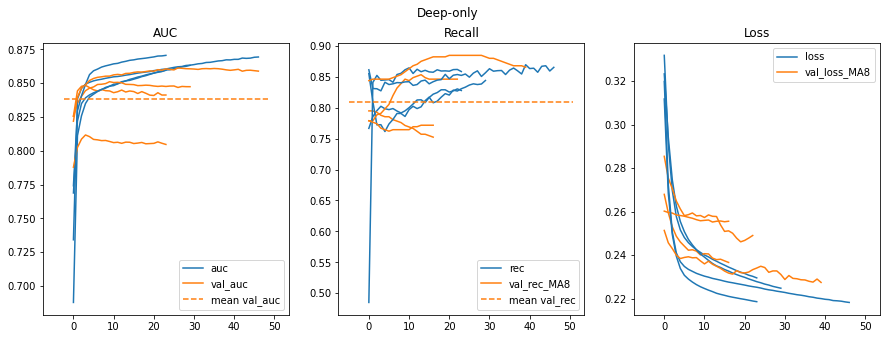

In [ ]:
show_perf(histories_Dfinal,y_preds_Dfinal,y_tests_final,title='Deep-only')

4-fold validation metrics:
Mean ROC-AUC:  0.8268
Mean Recall:   0.7705
Mean F1-score: 0.2076
Confusion matrices:
[[910 265]
 [ 14  39]]
[[859 316]
 [ 10  42]]
[[889 286]
 [ 17  35]]
[[862 313]
 [  7  45]]


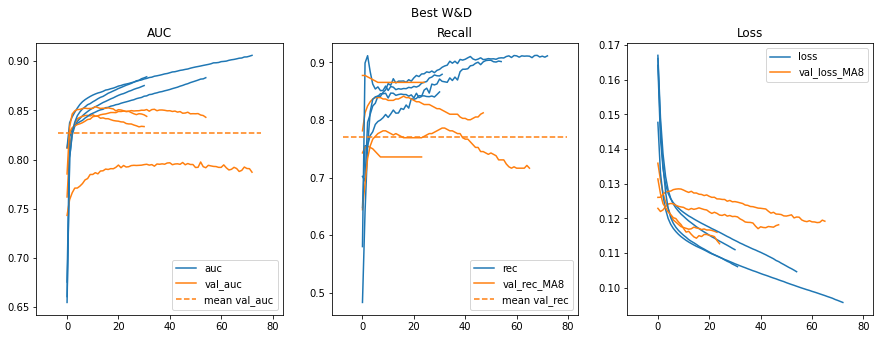

In [ ]:
show_perf(histories_WDfinal,y_preds_WDfinal,y_tests_final,title='Best W&D')

We further compare the two models using the ROC curve:

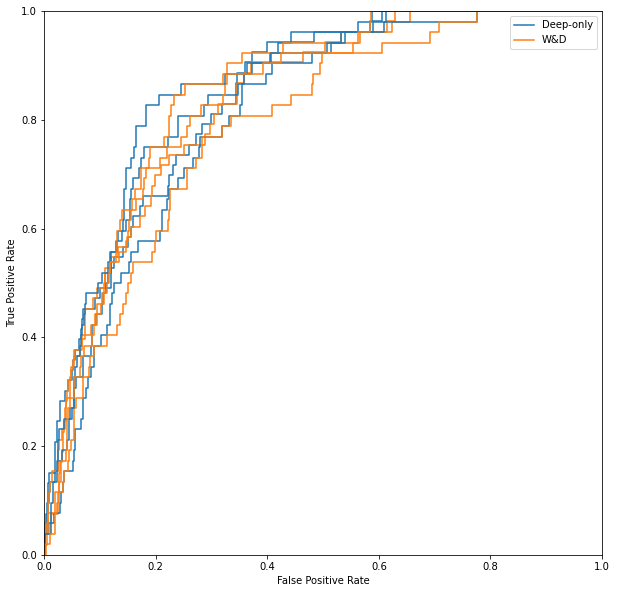

In [ ]:
def plot_roc_comparison(y_preds1,y_preds2,y_tests,name1=None,name2=None):
    nfolds = len(y_tests)

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('False Positive Rate') 
    ax.set_ylabel('True Positive Rate') 
    for k in range(nfolds):
        fpr,tpr,_ = roc_curve(y_tests[k], y_preds1[k])
        ax.plot(fpr,tpr,'tab:blue', label = name1 if k==0 else None) 
        fpr,tpr,_ = roc_curve(y_tests[k], y_preds2[k])
        ax.plot(fpr,tpr,'tab:orange', label = name2 if k==0 else None)  
    ax.legend() 
  
plot_roc_comparison(y_preds_Dfinal,y_preds_WDfinal,y_tests_final,'Deep-only','W&D') 

The ROC curves for the Deep-only network are higher on average, which matches with the higher ROC-AUC values shown previously.

The differences become more pronounced as we approach a higher True Positive Rate (TPR). As mentioned, we want TPR to be very high, as false negatives could very well mean the death of a patient.

The Deep-only network can achieve 95%+ TPR with a FPR of only 40%. For the best W&D to achieve 95%+ TPR, it requires 50-70% FPR.

###McNemar test on Deep-only and Best W&D network

We perform a McNemar test on the two models:

In [ ]:
mcnemar_test(y_preds_Dfinal,y_preds_WDfinal,y_tests_final,'Deep-only','Best W&D')

McNemar test: Deep-only vs Best W&D

    A   B   C   D   chi^2
k=0 894 12 55 267 26.3284
k=1 845 17 56 309 19.7808
k=2 830 22 94 281 43.4569
k=3 839 18 68 302 27.9186

Mean chi^2: 29.3712 ( Critical value 3.841 )
>>> Models are statistically DIFFERENT. ( >95% confidence ) <<<

Mean B: 17.25
Mean C: 68.25
>>> Best W&D is superior (C>B) <<<


The models are statistically different with a high degree of certainty ($\chi^2$ value is high enough for >99.99% confidence).

What our chosen metrics failed to reflect is the large difference in B and C for these models.

The value of C is over 3 times that of B; The best W&D is frequently correct where the Deep-only model is incorrect. Based on the confusion matrices shown previously, this likely reflects the W&D model's superior ability to classify negative examples, of which there are more. 

##Exceptional work

Here we capture and visualize embedding weights for deep network.

First, we gather the unique values of the categorical variables with **more than two classes**. We are interested in clustering, which is hard to describe when there are only two points.

In [ ]:
uniques = {}
for col in df.columns[df.dtypes!=float]:
    u = df[col].unique()
    #Do not show embeddings for binary features (clustering undefined)
    if len(u)<3: continue
    uniques[col+'_int'] = u
uniques

{'gender_int': array(['Male', 'Female', 'Other'], dtype=object),
 'smoking_status_int': array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
       dtype=object),
 'work_type_int': array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
       dtype=object)}

For each of these multi-class categorical features, we capture the weights and visualize the embedding, be it in 1D or 2D:

Name: gender_int_embed
Embedding: 3 => 1
Weights:
	 Male 	 [-0.04188306]
	 Female 	 [-0.01940148]
	 Other 	 [0.03781046]

Name: work_type_int_embed
Embedding: 5 => 2
Weights:
	 Private 	 [ 0.02178464 -0.03123755]
	 Self-employed 	 [0.04417817 0.02682343]
	 Govt_job 	 [ 0.10893285 -0.00710424]
	 children 	 [-0.20166126  0.04302685]
	 Never_worked 	 [-0.01942538  0.03699327]

Name: smoking_status_int_embed
Embedding: 4 => 2
Weights:
	 formerly smoked 	 [-0.03542754 -0.04294306]
	 never smoked 	 [0.05091084 0.03041833]
	 smokes 	 [ 0.01686148 -0.04317619]
	 Unknown 	 [-0.02468709  0.09720515]



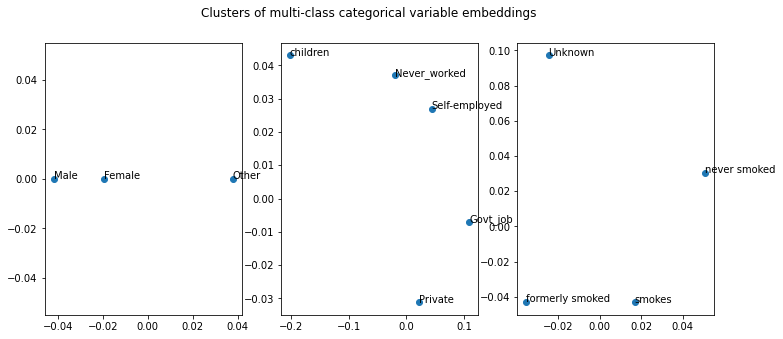

In [ ]:
fig,ax = plt.subplots(1,len(uniques),figsize=(12,5))
plt.suptitle("Clusters of multi-class categorical variable embeddings")
for i,col in enumerate(list(uniques.keys())):
    # Capture weights
    name    = col+'_embed'
    embed   = Dmodel.get_layer(name)
    weights = embed.get_weights()[0]

    # Determine in and out dimensions
    dim_in  = len(weights)
    dim_out = len(weights[0])

    print('Name:',name)
    print('Embedding:',dim_in,'=>',dim_out)
    print('Weights:')
    for j,w in enumerate(weights):
        print('\t',uniques[col][j],'\t',w)
    print()
    
    # Plot and label the embedding
    if dim_out==1:
        ax[i].scatter(weights,np.zeros(dim_in))
        for j,val in enumerate(uniques[col]):
            ax[i].annotate(val,(weights[j],0))
    elif dim_out==2:
        ax[i].scatter(*weights.T)
        for j,val in enumerate(uniques[col]):
            ax[i].annotate(val,weights[j])

The following observations are made:
* gender
    * "Male" and "Female" form a cluster relative to "Other". Incidence of stroke is higher in men than in women, but it is uncertain why "Other" would be so relatively distinct in terms of stroke outcome.

* work_type
    * "Never_worked" and "Self-employed" form a cluster, perhaps reflecting a sedentary, stay-at-home lifestyle associated with heart disease and stroke.
    * "Govt_job" and "Private" form a cluster, likely for the opposite reason of previous.
    * "children" - meaning those too young to be employed - is a group of its own. Stroke is very uncommon among this group.

* smoking_status
    * "formerly smoked" and "smokes" form a predictable cluster. Both imply worse health.
    * "never smoked" is in a group of its own, being the healthiest class.
    * "Unknown" Is roughly equidistant from the other groups, perhaps slightly closer to "never smoked". This may suggest that of patients classed as "Unknown", most are non-smokers. Probabilistically this would be the case (roughly 14% of Americans are smokers).

##Scratch work

In [ ]:
# with 2 classes for prediction variable, and we want to keep our testing set has similar ditributions as the original dataset with no overlap so that it somehow represents a real life distribution. 

In [ ]:
# # ========================================================
# # define objects that can encode each variable as integer    
# encoders = dict() # save each encoder in dictionary

# for col in cat_headers:
#     df[col] = df[col].str.strip()
#     # df_train[col] = df_train[col].str.strip()
#     # df_test[col] = df_test[col].str.strip()

#     # integer encode strings that are features
#     encoders[col] = LabelEncoder() # save the encoder
#     df[col+'_int'] = encoders[col].fit_transform(df[col])

#     # df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
#     # df_test[col+'_int'] = encoders[col].fit_transform(df_test[col])

# # ========================================================
# # scale the numeric, continuous variables
# for col in num_headers:
#     df[col] = df[col].astype(np.float)

#     # df_train[col] = df_train[col].astype(np.float)
#     # df_test[col] = df_test[col].astype(np.float)

#     ss = StandardScaler()
#     df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))
#     # df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
#     # df_test[col] = ss.fit_transform(df_test[col].values.reshape(-1, 1))

# # df_train.sample(5)

In [ ]:
# ========================================================
# define objects that can encode each variable as integer    
#encoders = dict() # save each encoder in dictionary

#for col in str_headers:
#    df[col] = df[col].str.strip()

    # integer encode strings that are features
#    encoders[col] = LabelEncoder() # save the encoder
#    df[col+'_int'] = encoders[col].fit_transform(df[col])

# ========================================================
# scale the numeric, continuous variables
#for col in num_headers:
#    df[col] = df[col].astype(np.float)
    
#    ss = StandardScaler()
#    df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))
    
#df.sample(5)

In [ ]:
# def get_split_df(df,y):
#     skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=None)
#     for itrain,itest in skf.split(df,y):
#         df_train = df[itrain]
#         df_test  = df[itest]
#     return df_train,df_test

# X_train = pd.DataFrame(X_train,columns=deep_features)
# X_test  = pd.DataFrame(X_test,columns=deep_features)
# y_train = pd.DataFrame(y_train,columns=['stroke'])
# y_test  = pd.DataFrame(y_test,columns=['stroke'])

# df_train = pd.concat([X_train,y_train], axis=1)
# df_test = pd.concat([X_test,y_test], axis=1)

In [ ]:
# cat_headers_ints = [x+'_int' for x in cat_headers]
# # we will forego one-hot encoding right now and instead just use all inputs as-is
# #   this is just to get an example running in Keras (its not a good idea)
# feature_headers = cat_headers_ints + num_headers
# # import pprint
# # pp = pprint.PrettyPrinter(indent=4)

# # print(f"We will use the following {len(feature_headers)} features:")
# # pp.pprint(feature_headers)

# # combine the features into a single large matrix
# # X_train = df_train[feature_headers].to_numpy()
# # X_test = df_test[feature_headers].to_numpy()

# # y_train = df_train['stroke'].values.astype(np.int)
# # y_test = df_test['stroke'].values.astype(np.int)

In [ ]:
# class weights for imbalanced problem
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_train),
#                                                  y_train)  

In [ ]:
# start by getting only the categorical variables
# these matrices are all integers
# X_cat = df[cat_headers_ints].to_numpy()

#embed_branches = []
#all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categorical variables
#inputs_cat = Input(shape=(len(cat_headers_ints),), 
#                     dtype='int64', 
#                     name='categorical')

# for each categorical variable
#for idx,col in enumerate(cat_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
#    N = max(df[col])+1
    # print(N)
    
    # this line of code does this: input_branch[:,idx]
#    x = tf.gather(inputs_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
#    x = Embedding(input_dim=N, 
#                  output_dim=N,#int(np.sqrt(N)), 
#                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
#    all_branch_outputs.append(x)

#inputs_num = Input(shape=(len(num_headers),), name='numeric')
#x_dense = Dense(units=17, activation='relu', name='num_1')(inputs_num)
    
#all_branch_outputs.append(x_dense)

    
# now concatenate the outputs and add a fully connected layer
# final_branch = concatenate(all_branch_outputs, name='concat_1')
# final_branch = Dense(units=1,
#                      activation='sigmoid', 
#                      name='combined')(final_branch)
#x = concatenate(all_branch_outputs, name='concat_1')
#x = Dense(units=50, activation='relu',kernel_initializer='he_uniform')(x)
#x = Dense(units=25, activation='relu')(x)
#x = Dense(units=10, activation='relu')(x)
#final_branch = Dense(1, activation='sigmoid')(x)

#model = Model(inputs=[inputs_cat,inputs_num], outputs=final_branch)

#model.compile(optimizer='adagrad',
#              loss='binary_crossentropy',#'mean_squared_error',
#              metrics=['accuracy'])

# model.summary()

In [ ]:
# plot_model(
#     model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='LR', expand_nested=False, dpi=96
# )

In [ ]:
# X_train=X_train.astype(np.int)
# X_test=X_test.astype(np.int)

In [ ]:

    # Ensure the same test set is used
    # assert len(y_tests1)==len(y_tests2)
    # assert np.array([(y_tests1[t]==y_tests2[t]).all() for t in range(nfolds)]).all()

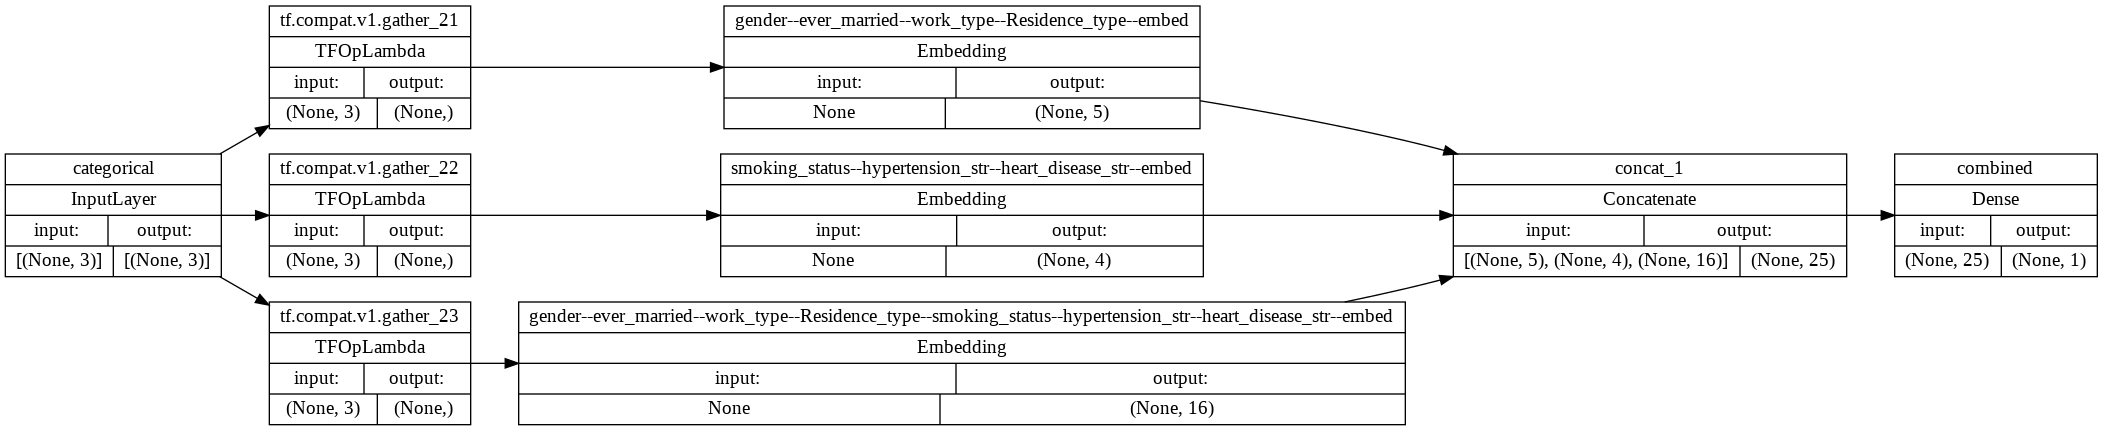

In [ ]:
# model = make_wide_deep()

# plot_model(
#     model, to_file='model.png', show_shapes=True, show_layer_names=True,
#     rankdir='LR', expand_nested=False, dpi=96
# )

In [ ]:
    # sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2)#,random_state=32)
    # for itrain,itest in sss.split(X,y):

In [ ]:
# cat_idxs   = [df.columns.get_loc(col) for col in cat_headers_ints]
# num_idxs   = [df.columns.get_loc(col) for col in num_headers]
# cross_idxs = [df.columns.get_loc(col) for col in cross_headers]
# # cross_idxs

In [ ]:
# features = cat_headers_ints+num_headers+cross_headers
# df[features].to_numpy()

In [ ]:
# def get_split_numcatcross_upsample(df,random_state=0):
#     features = cat_headers_ints+num_headers+cross_headers
#     X = df[features].to_numpy()
#     y = df[out_header].to_numpy()

#     sss = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
#     for itrain,itest in sss.split(X,y):
#         X_train, X_test = X[itrain], X[itest]
#         y_train, y_test = y[itrain], y[itest]

#     # Separate majority and minority classes
#     Xy = np.hstack((X_train,y_train))

#     # print(y_train.T==0)
#     Xy_negative = Xy[Xy[:,-1]==0]
#     Xy_positive = Xy[Xy[:,-1]==1]

#     num_neg = len(Xy_negative)
    
#     # Upsample minority class
#     Xy_positive_upsample = resample(Xy_positive, 
#                                     replace=True,      # sample with replacement
#                                     n_samples=num_neg, # to match majority class
#                                     random_state=random_state)    # reproducible results
    
#     # Combine majority class with upsampled minority class
#     Xy_upsampled = np.vstack([Xy_negative,
#                               Xy_positive_upsample])
    
#     np.random.shuffle(Xy_upsampled)

#     X_train_upsampled = Xy_upsampled[:,:-1]
#     y_train_upsampled = Xy_upsampled[:,-1].reshape(-1,1)
#     # print(y.dtype)
#     # print(X)

#     #=== Separate by type ===
#     cat_idxs   = [features.index(col) for col in cat_headers_ints]
#     num_idxs   = [features.index(col) for col in num_headers]
#     cross_idxs = [features.index(col) for col in cross_headers]

#     X_train_cat,   X_test_cat   = X_train_upsampled[:,cat_idxs], X_test[:,cat_idxs]
#     X_train_num,   X_test_num   = X_train_upsampled[:,num_idxs], X_test[:,num_idxs]
#     X_train_cross, X_test_cross = X_train_upsampled[:,cross_idxs], X_test[:,cross_idxs]
#     y_train,       y_test       = y_train_upsampled, y_test
    
#     # # Display new class counts
#     # print(Xy_upsampled[:,-1])
#     # # 1    576
#     # # 0    576
#     # # Name: balance, dtype: int64

#     return X_train_cat, X_train_num, X_train_cross, X_test_cat, X_test_num, X_test_cross, y_train, y_test

# X_train_cat, X_train_num, X_train_cross, X_test_cat, X_test_num, X_test_cross, y_train, y_test = get_split_numcatcross_upsample(df)

In [ ]:
# def multi_fit(models,epochs=50,labels=None):
#     X_train_cat, X_train_num, X_train_cross, X_test_cat, X_test_num, X_test_cross, y_train, y_test = get_split_numcatcross_upsample(df)
#     for model in models:
#         model.fit([X_train_cat, X_train_num, X_train_cross],
#                 y_train, epochs=epochs, batch_size=32, verbose=1)
#     for i,model in enumerate(models):
#         yhat = np.round(model.predict([X_test_cat, X_test_num, X_test_cross]))
#         print(mt.confusion_matrix(y_test,yhat))
#         print(mt.classification_report(y_test,yhat))

# # model = make_wide_deep()
# # multi_fit([model])

In [ ]:
# WD_model_1 = make_wide_deep(deep_shape =[50,25,10],
#                             activation ='relu',
#                             optimizer  ='adagrad')
# WD_model_2 = make_wide_deep(deep_shape =[10,5],
#                             activation ='relu',
#                             optimizer  ='sgd')
# WD_model_3 = make_wide_deep(deep_shape =[50,25,10],
#                             activation ='sigmoid',
#                             optimizer  ='adam')

# multi_fit([WD_model_1,WD_model_2,WD_model_3])